In [1]:
# Import python libraries
#
import importlib
import pickle
import os
import torch

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
importlib.reload(model)
importlib.reload(Simulation_config)
importlib.reload(utils)

# Print the sumarized simulation results
#
utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl')


("Configuration: Config_of_one_run(modelSize='MEDIUM', doPretraining=True, "
 'doTransferLearning=True, '
 "aggregation_Count='data/london_loadprofiles_37households_each.pkl', "
 'nrOfComunities=20, trainingHistory=466, modelInputHistory=24, '
 "usedModels=('SyntheticLoadProfile', 'KNN', 'PersistencePrediction', 'xLSTM', "
 "'LSTM', 'Transformer'), epochs=100)")
Latex Summary for this Configuration:  & 34.05 (7.92) & 17.13 (2.69) & 14.39 (1.45) & 12.60 (1.53) & 12.50 (1.42) & 12.71 (1.49)
("Configuration: Config_of_one_run(modelSize='MEDIUM', doPretraining=True, "
 'doTransferLearning=True, '
 "aggregation_Count='data/london_loadprofiles_37households_each.pkl', "
 'nrOfComunities=20, trainingHistory=61, modelInputHistory=24, '
 "usedModels=('SyntheticLoadProfile', 'KNN', 'PersistencePrediction', 'xLSTM', "
 "'LSTM', 'Transformer'), epochs=100)")
Latex Summary for this Configuration:  & 45.96 (10.73) & 33.10 (7.04) & 14.39 (1.45) & 29.01 (9.09) & 30.08 (9.47) & 27.52 (10.04)
("Configura

""


In [5]:
# Store specific predictions, for the paper 'use case' section.
#

importlib.reload(model)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Define a specific configuration
#
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            train_size = myConfig.trainingHistory,
                                            test_size = modelTrainer.test_set_size_days, 
                                            prediction_history = myConfig.modelInputHistory,
                                            )
community_id = 0  # chose one of many energy communites
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
path_to_trained_parameters = 'scripts/outputs/all_trained_models_20241107_0520.pth'
num_of_features = X['train'].shape[2]
P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

# Store the predicted power profiles
#
for model_type in Simulation_config.UsedModels.ALL:
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
    P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

startdate = modelAdapter.getStartDateFromIndex('test', 0)
file_path = "scripts/outputs/example_predictions.pkl"
with open(file_path, 'wb') as file:
    pickle.dump((P_el_predicted, startdate), file)

print(P_el_predicted.shape)
print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


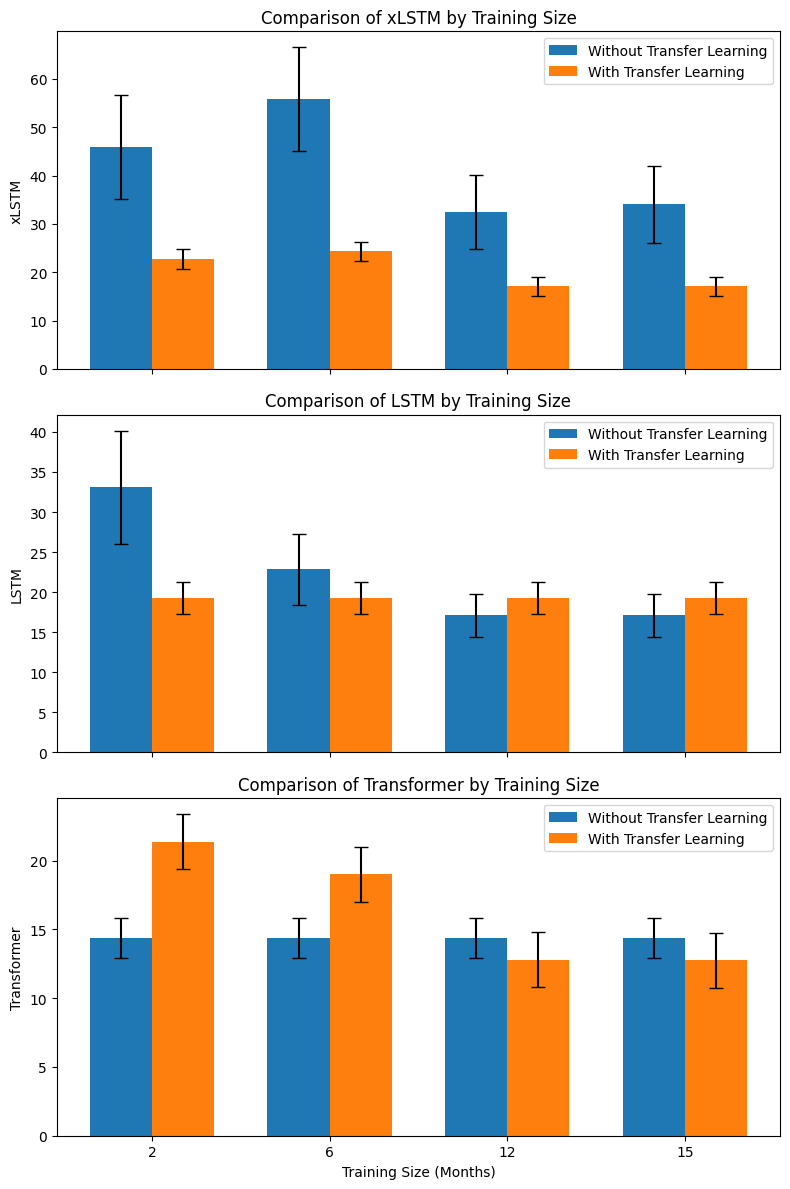

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Updating the data to include standard deviation values
data_with_transfer = {
    'Training Size (mo)': ['2', '6', '12', '15'],
    'xLSTM': [45.96, 55.80, 32.41, 34.05],
    'xLSTM Std': [10.73, 10.72, 7.69, 7.92],
    'LSTM': [33.10, 22.83, 17.11, 17.13],
    'LSTM Std': [7.04, 4.42, 2.66, 2.69],
    'Transformer': [14.39, 14.39, 14.39, 14.39],
    'Transformer Std': [1.45, 1.45, 1.45, 1.45]
}

data_without_transfer = {
    'Training Size (mo)': ['2', '6', '12', '15'],
    'xLSTM': [22.73, 24.34, 17.09, 17.11],
    'xLSTM Std': [2, 2, 2, 2],
    'LSTM': [19.30, 19.30, 19.30, 19.30],
    'LSTM Std': [2, 2, 2, 2],
    'Transformer': [21.38, 19.01, 12.78, 12.77],
    'Transformer Std': [2, 2, 2, 2]
}

# Convert dictionaries to DataFrames
df_with_transfer = pd.DataFrame(data_with_transfer)
df_without_transfer = pd.DataFrame(data_without_transfer)

# Define the positions for bars to display them side-by-side
bar_width = 0.35  # Width of each bar
x = np.arange(len(df_with_transfer['Training Size (mo)']))  # The label locations

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Titles for each column
titles = ["xLSTM", "LSTM", "Transformer"]

# Plot each column in a separate subplot with error bars
for i, col in enumerate(['xLSTM', 'LSTM', 'Transformer']):
    std_col_with = f"{col} Std"
    std_col_without = f"{col} Std"
    
    axs[i].bar(x - bar_width/2, df_with_transfer[col], width=bar_width, yerr=df_with_transfer[std_col_with], 
               capsize=5, label='Without Transfer Learning')
    axs[i].bar(x + bar_width/2, df_without_transfer[col], width=bar_width, yerr=df_without_transfer[std_col_without], 
               capsize=5, label='With Transfer Learning')
    
    axs[i].set_ylabel(titles[i])
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(df_with_transfer['Training Size (mo)'])
    axs[i].legend()
    axs[i].set_title(f"Comparison of {titles[i]} by Training Size")

# Set common X label
plt.xlabel("Training Size (Months)")
plt.tight_layout()
plt.show()

